# Setup Jupyter Notebook

In [1]:
from pathlib import Path
import sys

notebook_directory_parent = Path.cwd().resolve().parent.parent
if str(notebook_directory_parent) not in sys.path:
    sys.path.append(str(notebook_directory_parent))

In [2]:
print(notebook_directory_parent)

/home/topolo/PropD/Propulsion/T1000


In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import control
import control.matlab as controlmatlab

cf. [Discrete control #1: Introduction and overview, Aug. 11, 2017](https://youtu.be/14cMhrp5wlk), [Brian Douglas](https://www.youtube.com/channel/UCq0imsn84ShAe9PBOFnoIrg)

In [2]:
G = control.tf([1,], [0.2, 1])
print(G)


    1
---------
0.2 s + 1



Text(0.5, 1.0, 'Step Response')

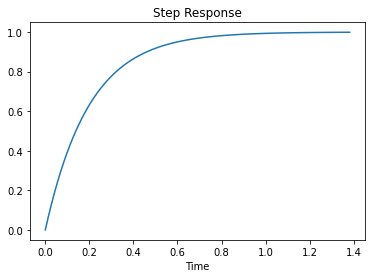

In [14]:
t, y = control.step_response(G)
plt.plot(t, y)
plt.xlabel('Time')
plt.title('Step Response')

In [7]:
unit_step = control.tf([1,], [1, 0])
print(unit_step)


1
-
s




     1
-----------
0.2 s^2 + s



Text(0.5, 1.0, 'Ramp Response')

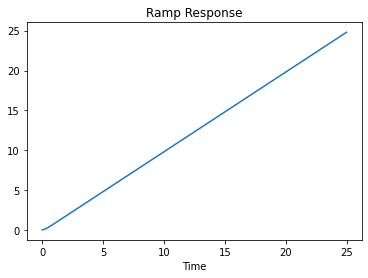

In [15]:
print(G * unit_step)
t, y = control.step_response(G * unit_step)
plt.plot(t, y)
plt.xlabel('Time')
plt.title('Ramp Response')

This is hard to see, let's compare to just a ramp

Text(0.5, 1.0, 'Ramp Response Difference')

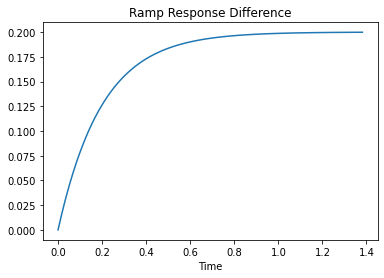

In [16]:
t_diff, y_diff = control.step_response(unit_step - G * unit_step)
plt.plot(t_diff, y_diff)
plt.xlabel('Time')
plt.title('Ramp Response Difference')

Steady State Error is 0.2 (20%), greater than say requirement of Steady State Error being < 2% for ramp input.

Since it's first-order, open loop, it has infinite phase margin, no amount of phase lag will make system unstable.

Create the controller transfer function.

In [17]:
C = control.tf([500, 50], [100, 1, 0])
print(C)


500 s + 50
-----------
100 s^2 + s



Create the feedback system and find the closed loop transfer function.

In [20]:
CL = control.feedback(C*G, 1)
print(CL)


          500 s + 50
-------------------------------
20 s^3 + 100.2 s^2 + 501 s + 50



Check the ramp steady state error like we did before

Text(0.5, 1.0, 'ramp steady state error')

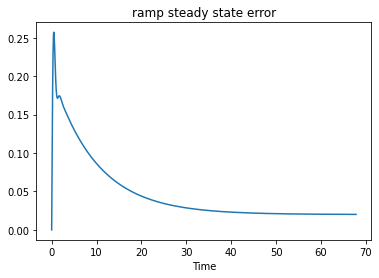

In [21]:
t, y = control.step_response(unit_step - CL * unit_step)
plt.plot(t, y)
plt.xlabel('Time')
plt.title('ramp steady state error')

There's a jump in error in the beginning, and then goes to 2 percent error.

To find phase margin we look at Bode plot of open loop system.

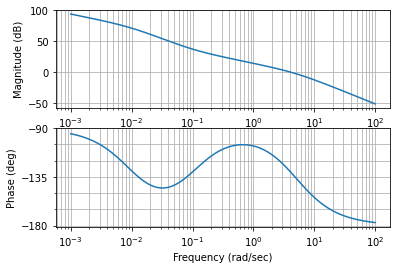

In [22]:
mag, phase, omega = control.matlab.bode(C*G)

In [25]:
# wpc = crossover frequency, wgc = gain crossover frequency (where gain crosses 1)
gain_margin, phase_margin, wpc, wgc = control.margin(C*G)
print(gain_margin)
print(phase_margin) # 50.5 phase margin, beating a 48 degree phase margin
print(wpc)
print(wgc)

inf
50.50959723786886
nan
3.9316674763909094


We can convert to a discrete transfer function in the z domain using c2d()   
Default conversion method is Zero Order Hold (ZOH)

In [27]:
# c2d returns sysd - Discrete time system, with sampling rate Ts
Cz = control.matlab.c2d(C, 0.1) # default 'zoh'
print(Cz)


  0.5022 z - 0.4973
---------------------
z^2 - 1.999 z + 0.999

dt = 0.1



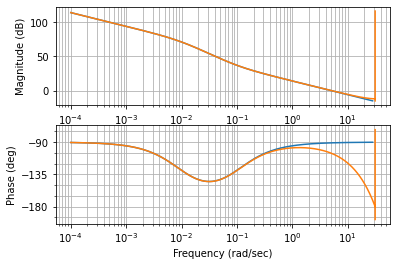

In [28]:
mag, phase, omega = control.matlab.bode(C, Cz)

In [31]:
gain_margin, phase_margin, wpc, wgc = control.margin(Cz)
print(gain_margin)
print(phase_margin) 
print(wpc)
print(wgc)

inf
74.52149451559609
nan
5.05456707098255


cf. [Discrete control #2: Discretize! Going from continuous to discrete domain](https://youtu.be/rL_1oWrOplk) [Brian Douglas](https://www.youtube.com/channel/UCq0imsn84ShAe9PBOFnoIrg)

In [33]:
G_s = control.tf([1,], [1, 3, 2])
print(G_s)
Z_g_k = control.matlab.c2d(G_s, 1., 'zoh')
print(Z_g_k)


      1
-------------
s^2 + 3 s + 2


   0.1998 z + 0.0735
------------------------
z^2 - 0.5032 z + 0.04979

dt = 1.0



In [34]:
np.exp(-0.1)

0.9048374180359595

In [35]:
G = control.tf([1], [1, 1])
print(G)
Ts = 0.1 # seconds


  1
-----
s + 1



Discretization is done with the function c2d

In [36]:
help(control.matlab.c2d)

Help on function c2d in module control.dtime:

c2d(sysc, Ts, method='zoh', prewarp_frequency=None)
    Convert a continuous time system to discrete time by sampling
    
    Parameters
    ----------
    sysc : LTI (StateSpace or TransferFunction)
        Continuous time system to be converted
    Ts : real > 0
        Sampling period
    method : string
        Method to use for conversion, e.g. 'bilinear', 'zoh' (default)
    
    prewarp_frequency : real within [0, infinity)
        The frequency [rad/s] at which to match with the input continuous-
        time system's magnitude and phase
    
    Returns
    -------
    sysd : linsys
        Discrete time system, with sampling rate Ts
    
    Notes
    -----
    See :meth:`StateSpace.sample` or :meth:`TransferFunction.sample`` for
    further details.
    
    Examples
    --------
    >>> sysc = TransferFunction([1], [1, 2, 1])
    >>> sysd = sample_system(sysc, 1, method='bilinear')



In [40]:
Gz = control.matlab.c2d(G, Ts, 'zoh')
print(Gz)
Gf = control.matlab.c2d(G, Ts, 'foh')
print(Gf)
Gi = control.matlab.c2d(G, Ts, 'impulse')
print(Gi)
Gt = control.matlab.c2d(G, Ts, 'tustin')
print(Gt)
Gm = control.matlab.c2d(G, Ts, 'matched')
print(Gm)
Gb = control.matlab.c2d(G, Ts, 'bilinear')
print(Gb)


 0.09516
----------
z - 0.9048

dt = 0.1


0.04837 z + 0.04679
-------------------
    z - 0.9048

dt = 0.1


  0.1 z
----------
z - 0.9048

dt = 0.1


0.04762 z + 0.04762
-------------------
    z - 0.9048

dt = 0.1


 0.09516
----------
z - 0.9048

dt = 0.1


0.04762 z + 0.04762
-------------------
    z - 0.9048

dt = 0.1



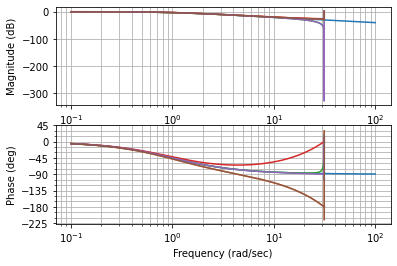

In [41]:
mag, phase, omega = control.matlab.bode(G, Gz, Gf, Gi, Gt, Gm)
plt.legend()

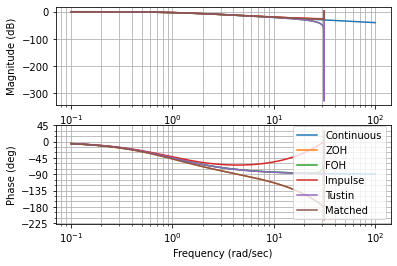

In [43]:
mag, phase, omega = control.bode_plot([G, Gz, Gf, Gi, Gt, Gm])
plt.gca().legend(('Continuous', 'ZOH', 'FOH', 'Impulse', 'Tustin', 'Matched'))

In [45]:
y, T = control.matlab.step(G)
yz, Tz = control.matlab.step(Gz)
yf, Tf = control.matlab.step(Gf)
yi, Ti = control.matlab.step(Gi)
yt, Tt = control.matlab.step(Gt)
ym, Tm = control.matlab.step(Gm)

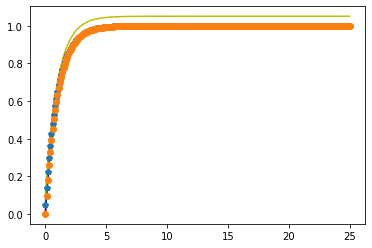

In [48]:
plt.plot(T, y, 'r')
plt.plot(Tz, yz, 'b')
plt.plot(Tf, yf, 'g')
plt.plot(Ti, yi, 'y')
plt.plot(Tt, yt, 'p')
plt.plot(Tm, ym, 'o')
plt.show()

In [49]:
print(Gi)


  0.1 z
----------
z - 0.9048

dt = 0.1



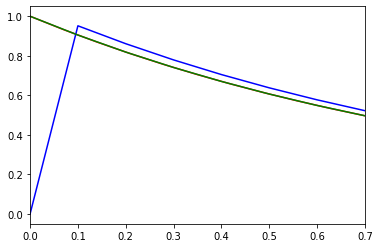

In [52]:
T, y = control.impulse_response(G)
Ti, yi = control.impulse_response(Gi)
Tz, yz = control.impulse_response(Gz)
plt.plot(T, y, 'r')
plt.plot(Tz, yz, 'b')
plt.plot(Ti, yi, 'g')
plt.xlim([0.0, 0.7])
plt.show()

cf. [Discrete control #3: Designing for the zero-order hold](https://youtu.be/yetLPW9sQaI) Brian Douglas

In [4]:
C = control.tf([500, 50], [100, 1, 0])
print(C)


500 s + 50
-----------
100 s^2 + s



In [5]:
Ct = control.matlab.c2d(C, 0.2, 'tustin')
print(Ct)


0.5045 z^2 + 0.00999 z - 0.4945
-------------------------------
     z^2 - 1.998 z + 0.998

dt = 0.2



[Discrete control #4: Discretize with the matched method](https://youtu.be/TPNiLqsdwNI) Brian Douglas

In [9]:
# No zeroes, poles at -1, -2, gain of 3
b, a = control.matlab.zpk2tf([], [-1, -2], 3)
print(b)
print(a) # Confirms this is same transfer function as written before.

[3.]
[1. 3. 2.]


In [10]:
zero_frequency_DC_gain = control.dcgain(control.tf([3], [1,3,2]))
print(zero_frequency_DC_gain)

1.5


In [12]:
Gz = control.TransferFunction([1], [1, -0.5032, 0.04978], 1)
print(Gz)


           1
------------------------
z^2 - 0.5032 z + 0.04978

dt = 1



In [13]:
G = control.tf([3,], [1, 3, 2])
print(G)


      3
-------------
s^2 + 3 s + 2



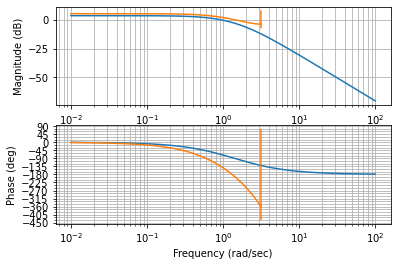

In [14]:
mag, phase, omega = control.matlab.bode(G, Gz)

Text(0.5, 1.0, 'Step Response')

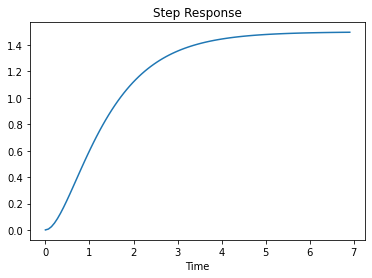

In [15]:
t, y = control.step_response(G)
plt.plot(t, y)
plt.xlabel('Time')
plt.title('Step Response')

Text(0.5, 1.0, 'Step Response')

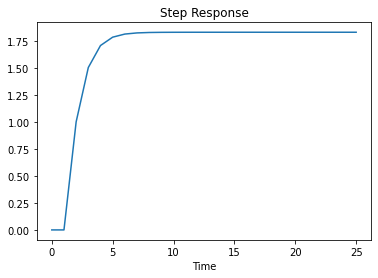

In [16]:
t, y = control.step_response(Gz)
plt.plot(t, y)
plt.xlabel('Time')
plt.title('Step Response')

Text(0.5, 1.0, 'Step Response')

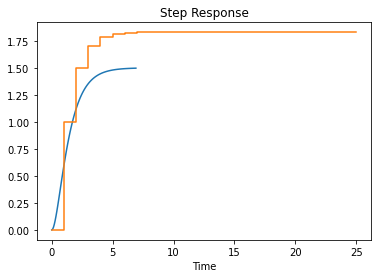

In [18]:
t, y = control.step_response(G)
tz, yz = control.step_response(Gz)
plt.plot(t, y)
plt.step(tz, yz)
plt.xlabel('Time')
plt.title('Step Response')

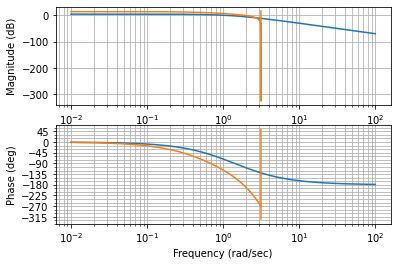

In [19]:
Gz_proper = control.tf([1, 1], [1, -0.5032, -.04978], 1)
mag, phase, omega = control.matlab.bode(G, Gz_proper)

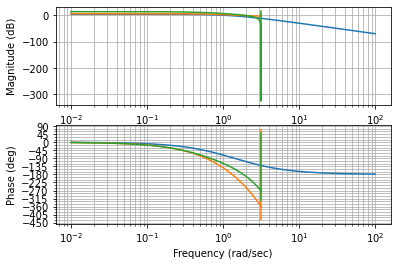

In [21]:
mag, phase, omega = control.matlab.bode(G, Gz, Gz_proper)

Text(0.5, 1.0, 'Step Response')

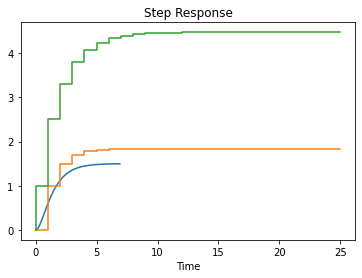

In [22]:
t, y = control.step_response(G)
tz, yz = control.step_response(Gz)
tzp, yzp = control.step_response(Gz_proper)
plt.plot(t, y)
plt.step(tz, yz)
plt.step(tzp, yzp)
plt.xlabel('Time')
plt.title('Step Response')

In [27]:
import sympy
z = sympy.Symbol('z')
print( ((z - 0.3679) * (z -0.1353)).as_poly() )

Poly(1.0*z**2 - 0.5032*z + 0.04977687, z, domain='RR')


In [35]:
print(G)
print(G.zero())
print(G.pole())
Gz_matched = control.matlab.c2d(G, 1.0, 'matched')
print(Gz_matched)


      3
-------------
s^2 + 3 s + 2

[]
[-2. -1.]

          1.64
------------------------
z^2 - 0.5032 z + 0.04979

dt = 1.0



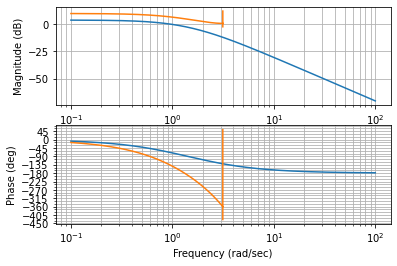

In [31]:
mag, phase, omega = control.matlab.bode(G, Gz_matched)

Text(0.5, 1.0, 'Step Response')

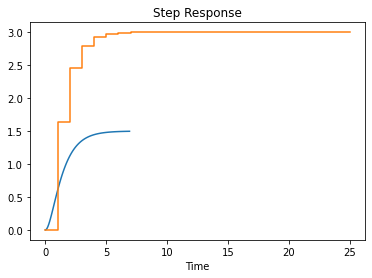

In [32]:
t, y = control.step_response(G)
tm, ym = control.step_response(Gz_matched)
plt.plot(t, y)
plt.step(tm, ym)
plt.xlabel('Time')
plt.title('Step Response')


   0.4099 z + 0.4099
------------------------
z^2 - 0.5032 z + 0.04977

dt = 1



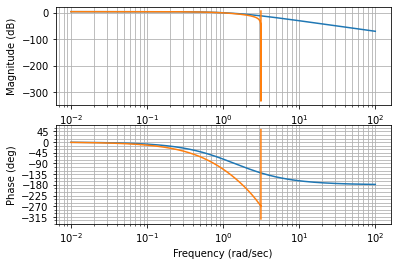

In [36]:
Gz_matched_hand = control.tf([0.4099, 0.4099], [1, -0.5032, 0.04977], 1)
print(Gz_matched_hand)
mag, phase, omega = control.matlab.bode(G, Gz_matched_hand)

Text(0.5, 1.0, 'Step Response')

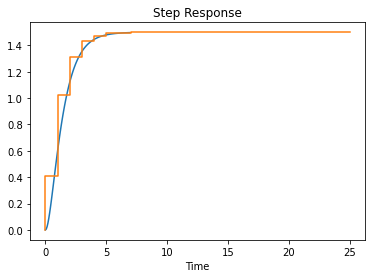

In [37]:
t, y = control.step_response(G)
tm, ym = control.step_response(Gz_matched_hand)
plt.plot(t, y)
plt.step(tm, ym)
plt.xlabel('Time')
plt.title('Step Response')

cf. [Discrete control #5: The bilinear transform](https://youtu.be/88tWmyBaKIQ)

In [39]:
G = control.tf([2,], [1, 1])
print(G)


  2
-----
s + 1



In [40]:
Gz = control.matlab.c2d(G, 1, 'tustin')
print(Gz)


0.6667 z + 0.6667
-----------------
   z - 0.3333

dt = 1



In [41]:
Gz = control.matlab.c2d(G, 0.1, 'tustin')
print(Gz)


0.09524 z + 0.09524
-------------------
    z - 0.9048

dt = 0.1



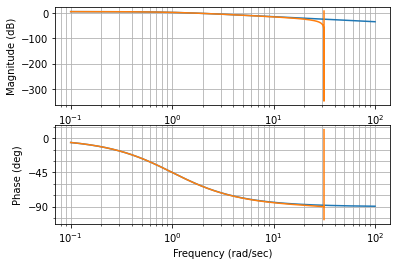

In [42]:
mag, phase, omega = control.matlab.bode(G, Gz)

Text(0.5, 1.0, 'Step Response')

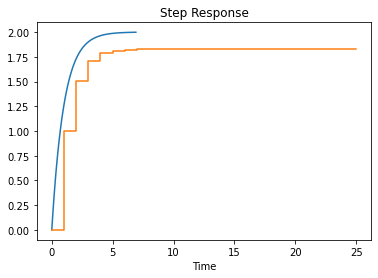

In [43]:
t, y = control.step_response(G)
tm, ym = control.step_response(Gz)
plt.plot(t, y)
plt.step(tz, yz)
plt.xlabel('Time')
plt.title('Step Response')

cf. [Discrete control #6: z-plane warping and the bilinear transform](https://youtu.be/NRbGPgcLhU0)

In [44]:
G = control.tf([1, 0, 0.01], [1, 0.1, 0.01])
print(G)


    s^2 + 0.01
------------------
s^2 + 0.1 s + 0.01



In [47]:
# Set sample time to 2 seconds
T = 2
# Set critical frequency to 0.1 rad/s
W0 = 0.1
# Set quality factor to 1
Q = 1

In [48]:
# Create our s-domain notch filter
G1 = control.tf([1, 0, W0*W0], [1, W0/Q, W0*W0])
print(G1)


    s^2 + 0.01
------------------
s^2 + 0.1 s + 0.01



/home/topolo/PropD/Propulsion/venv/lib64/python3.8/site-packages/control/freqplot.py:358: RuntimeWarning: divide by zero encountered in log10
  ax_mag.semilogx(omega_plot, 20 * np.log10(mag_plot),


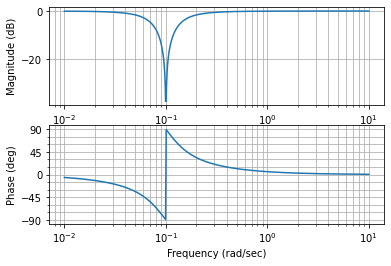

In [49]:
mag, phase, omega = control.matlab.bode(G1)

Notch at 0.1 radians per second.

In [50]:
# Let's use the bilinear transform (Tustin) to convert to z-domain
G1t = control.matlab.c2d(G1, T, 'tustin')
print(G1t)


0.9099 z^2 - 1.784 z + 0.9099
-----------------------------
   z^2 - 1.784 z + 0.8198

dt = 2



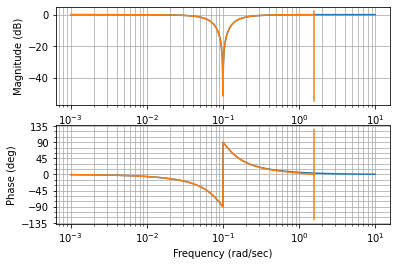

In [51]:
mag, phase, omega = control.matlab.bode(G1, G1t)

Blue digital filter lies on top of analog filter, good.
Change W0, critical frequency.

In [52]:
W0 = 0.7
G1 = control.tf([1, 0, W0*W0], [1, W0/Q, W0*W0])
print(G1)


    s^2 + 0.49
------------------
s^2 + 0.7 s + 0.49



In [53]:
G1t = control.matlab.c2d(G1, T, 'tustin')
print(G1t)


0.6804 z^2 - 0.4658 z + 0.6804
------------------------------
   z^2 - 0.4658 z + 0.3607

dt = 2



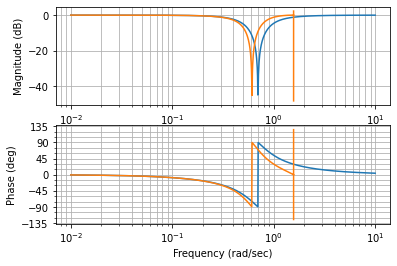

In [54]:
mag, phase, omega = control.matlab.bode(G1, G1t)

In [57]:
Wa = 0.1 # rad / sec
Wd = 1/(2j) * np.log((1 + Wa * 1j) / (1 - Wa * 1j))
print(Wd)

(0.09966865249116204+7.694615022154551e-18j)


In [58]:
Wa = 0.7 # rad / sec
Wd = 1/(2j) * np.log((1 + Wa * 1j) / (1 - Wa * 1j))
print(Wd)

(0.6107259643892086+1.024534670375564e-17j)


In [59]:
Wa = 2.5 # rad / sec
Wd = 1/(2j) * np.log((1 + Wa * 1j) / (1 - Wa * 1j))
print(Wd)

(1.1902899496825317-1.7227598657976568e-17j)


In [60]:
W0 = 0.7
T = 2
Q = 1
G7 = control.tf([1, 0, W0*W0], [1, W0/Q, W0*W0])
print(G7)


    s^2 + 0.49
------------------
s^2 + 0.7 s + 0.49



In [63]:
# G7 is our s-domain notch filter at 0.7 rad/s
# Now we'll convert it to z-domain with bilinear transform and prewarping
#G7t = control.matlab.c2d(G7, T, ['Method', 'tustin', 'PrewarpFrequency',W0])
G7t = control.sample_system(G7, T, 'tustin', prewarp_frequency=W0)
print(G7t)


0.6804 z^2 - 0.4658 z + 0.6804
------------------------------
   z^2 - 0.4658 z + 0.3607

dt = 2



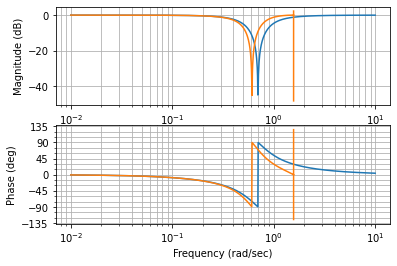

In [64]:
mag, phase, omega = control.matlab.bode(G7, G7t)